# KNeighbors Code

In [1]:
import numpy as np

In [2]:
class KMeans:
    """
    This function takes in 2D data and applies KMeans clustering. Returns prediction of assignment of data to clusters. 
    """
    def __init__(self, n_clusters = 10, max_iters = 100, tol = 1e-4, random_seed = None):
        self.n_clusters = n_clusters
        self.max_iters = max_iters
        self.tol = tol
        self.random_seed = random_seed
        self.assignments = None
        self.centroids = None

    def _check_x(self, x):
        x = np.asarray(x)
        if x.ndim == 1:
            x = x.reshape(1,-1)
        elif x.ndim != 2:
            raise ValueError(f"Data is {x.ndim}D, must be 2D")
        return x

    def fit(self,x):
        """
        Function takes in 2D data, initializes centroids, and runs loop assigning points to clusters, computing centroids, checking convergence, 
        and updating centroids. 
        """
        x = self._check_x(x)
        np.random.seed(self.random_seed)
        self.n_samples, self.n_features = x.shape
        if self.n_samples < self.n_clusters:
            raise ValueError(f"Need as many samples as clusters!")

        self.centroids = x[np.random.choice(self.n_samples,self.n_clusters, replace = False)] # initializes centroids from randomly chosen points
        for _ in range(self.max_iters):
            self.assignments = self.assign_clusters(x)
            new_centroids = self.compute_centroids(x) # new_centroids and centroids have shape (n_clusters, n_features)
            if np.all(np.sum((new_centroids - self.centroids)**2, axis = 1 )<self.tol**2): # inner ( - )**2 has shape (n_clusters,neatures),sum over feautures has shape (n_clusters,),() <tol**2 is 1D boolean array of tuples shape(n_clusters,)
                self.centroids = new_centroids
                break
            self.centroids = new_centroids
        self.assignments = self.assign_clusters(x)
        return self

    def assign_clusters(self,x):
        """
        Assign points to cluster by squared L2. For each point x[i], assign to cluster C_j where x[i] is closest in squared L2 distance to centroid c_j in C_j. 
        """
        x = self._check_x(x) 
        differences = np.sum((x[:,np.newaxis,:] - self.centroids[np.newaxis,:,:])**2,axis = 2)  # inner ( - )**2 has shape (n_samples, n_clusters, n_features), sum has shape (n_samples, n_clusters,)
        assignments = np.argmin(differences, axis = 1) # has shape (n_samples,)
        return assignments
    def compute_centroids(self,x):
        """
        Compute centroid for each cluster by finding the average value. 
        """
        x = self._check_x(x)
        counts = np.zeros(self.n_clusters) # to count number of points in each cluster
        new_centroids = np.zeros((self.n_clusters, self.n_features)) # we'll use new_centroids to first store sums of all points in each centroid

        np.add.at(new_centroids,self.assignments,x) #for each i in range(n_samples): new_centroids[assignment[i]]+= x[i]
        np.add.at(counts, self.assignments,1) # for each i in range(n_samples): counts[self.assignments[i]]+=1. example: for point x[1], assignments[1] = 2,this adds 1 to counts[2]

        # to divide, we need to prevent dividing by zero, hence accounting for empty clusters. So we will handle those seperately.
        nonempty_clusters = counts > 0
        new_centroids[nonempty_clusters] /= counts[nonempty_clusters][:,None] # counts has shape (n_clusters,) -> shape (n_clusters, 1) to broadcast division across features

        empty_clusters = np.where(counts == 0)[0] # counts has shape (n_clusters,), empty_clusters has shape (n_clusters), 1D array of indices of empty clusters
        new_centroids[empty_clusters] = x[ np.random.choice(self.n_samples, len(empty_clusters), replace = False)]

        return new_centroids 
        

    def predict(self, x):
        x = self._check_x(x)
        return self.assign_clusters(x)

# Data Prep

In [3]:
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler

mnist = fetch_openml("mnist_784", version = 1, as_frame = False)
X = mnist.data
y = mnist.target

scaler = StandardScaler()
x_scaled = scaler.fit_transform(X)

idx = np.random.choice(x_scaled.shape[0], 2000, replace = False)
x_small = x_scaled[idx]
y_small = y[idx]



kmeans = KMeans(n_clusters=10, max_iters=100, tol=1e-4, random_seed=42)
kmeans.fit(x_small)
labels = kmeans.predict(x_small)

from sklearn.metrics import normalized_mutual_info_score

nmi = normalized_mutual_info_score(y_small, labels)
print("Normalized Mutual Information:", nmi)


Normalized Mutual Information: 0.40056384425153724


# Visualize Centroids

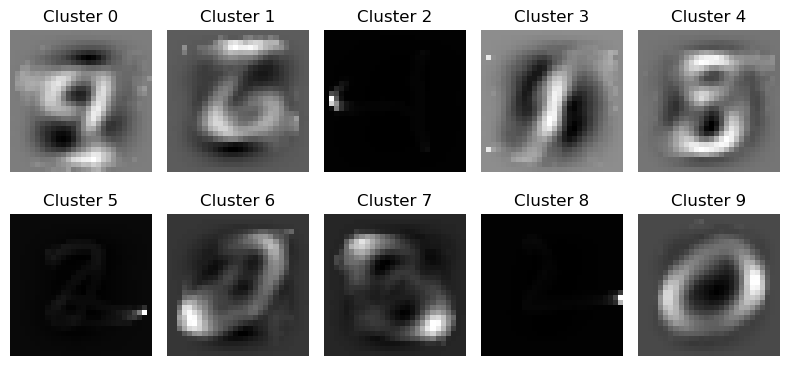

In [4]:
import matplotlib.pyplot as plt

centroids = kmeans.centroids.reshape(10, 28, 28)

plt.figure(figsize=(8, 4))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(centroids[i], cmap="gray")
    plt.title(f"Cluster {i}")
    plt.axis("off")

plt.tight_layout()
plt.show()


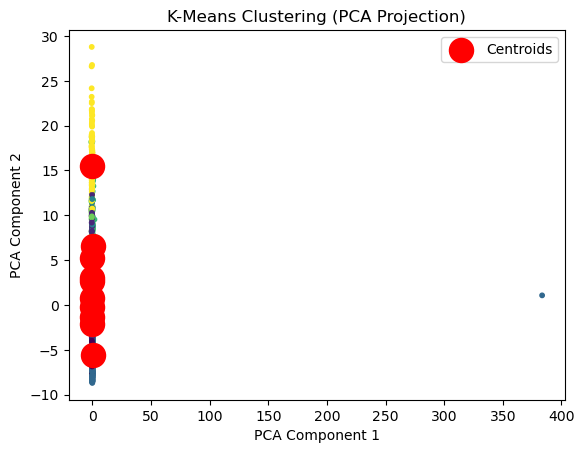

In [5]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_2d_small = pca.fit_transform(x_small)
C_2d = pca.transform(kmeans.centroids)

import matplotlib.pyplot as plt

plt.scatter(X_2d_small[:, 0], X_2d_small[:, 1], c=kmeans.assignments, cmap="viridis", s=10)
plt.scatter(C_2d[:, 0], C_2d[:, 1], c="red", s=300, label="Centroids")

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("K-Means Clustering (PCA Projection)")
plt.legend()
plt.show()

